# Grover's Search Algorithm

Grover's algorithm is arguably one of the canonical quantum algorithms that kick-started the field of quantum computing. In the future, it could possibly serve as a hallmark application of quantum computing. Grover's algorithm allows us to find a particular register in an unordered database with $N$ entries in just $O(\sqrt{N})$ steps, compared to the best classical algorithm taking on average $N/2$ steps, thereby providing a __quadratic speedup__. For large databases (with a large number of entries, $N$), a quadratic speedup can provide a significant advantage. For a database with one million entries, a quantum computer running Grover's algorithm would need about 1000 runs, while a classical computer would need, on average, $500,000$ runs.

In this notebook, we implement Gover's algorithm based on ion-trap experiments [1]. In particular, we implement the phase oracle (see Figure 1d and 1e of this paper). For a compherensive description of the algorithm see Chapter 6 of [2]. In the ion-trap experiments [1], the oracle encodes bitstrings with length three. Here, we extend the bitstrings to arbitrary length. We use generalized Toffoli gates to construct the oracle. Following reference [3], the generalized Toffoli gates is decomposed into Toffoli gates. 


---
# References <a name="ref"></a>

[1] C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017). "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7. [arXiv:1703.10535](https://arxiv.org/abs/1703.10535).

[2] Nielsen, Michael A., Chuang, Isaac L. (2010). Quantum Computation and Quantum Information (2nd ed.). Cambridge: Cambridge University Press.

[3] J. M. Baker, C. Duckering, A. Hoover, F. T. Chong (2019). Decomposing Quantum Generalized Toffoli with an Arbitrary Number of Ancilla. [arXiv:1904.01671](https://arxiv.org/abs/1904.01671).

In [1]:
from notebook_plotting import plot_bitstrings_formatted
import numpy as np

%matplotlib inline

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.tracking import Tracker

from braket.experimental.algorithms.grover_search import (
    build_oracle,
    grover_search,
)

In [2]:
solution = "111"
n_qubits = len(solution)

oracle = build_oracle(solution)
circuit = grover_search(oracle, n_qubits=n_qubits, n_reps=1)

print("number of data qubits: ", n_qubits)
print("number of ancilla qubits: ", circuit.qubit_count - n_qubits)
print(circuit)

number of data qubits:  3
number of ancilla qubits:  3
T  : |0| 1 |2| 3 |4|5| 6 |7| 8 |9|10|Result Types|
                                                  
q0 : -H-C-------C-H-X-C-------C-X-H--Probability--
        |       |     |       |      |            
q1 : -H-|-C---C-|-H-X-|-C---C-|-X-H--Probability--
        | |   | |     | |   | |      |            
q2 : -H-|-C---C-|-H-X-|-C---C-|-X-H--Probability--
        | |   | |     | |   | |                   
q3 : ---X-|-C-|-X-----X-|-C-|-X-------------------
          | | |         | | |                     
q4 : -----X-C-X---------X-C-X---------------------
            |             |                       
q5 : -X-H---X-H---X-X-H---X-H---X-----------------

T  : |0| 1 |2| 3 |4|5| 6 |7| 8 |9|10|Result Types|


# Run on a local simulator
We demonstrate Grover's algorithm on a classical simulator first. You can choose between a local simulator or an on-demand simulator.

In [3]:
local_simulator = LocalSimulator()

In [4]:
task = local_simulator.run(circuit, shots=1000)
print(task)

LocalQuantumTask('id':454fcd63-271b-4ef1-8fc2-a160167ca461)


In [5]:
result = task.result()
probabilities = result.values[0]
print(probabilities)

[0.027 0.032 0.025 0.044 0.035 0.032 0.027 0.778]


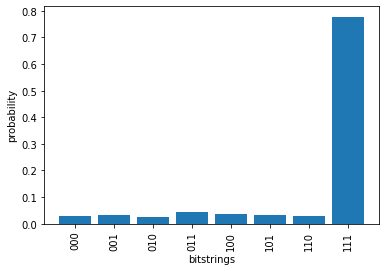

In [6]:
plot_bitstrings_formatted(probabilities)

# Run on a QPU or a on-demand simulator

Now we run on IonQ. Toffolo gate (CCNot) is not a supported gate of IonQ device. We use the `decompose_ccnot=True` to decompose the Toffoli gate into CNot, Ti, T and H gates. 

In [7]:
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice") # QPU
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1") # on-demand simulator

In [8]:
from braket.tracking import Tracker

tracker = Tracker().start()

In [10]:
oracle = build_oracle(solution, decompose_ccnot=True)
circuit_qpu = grover_search(oracle, n_qubits=n_qubits, n_reps=1, decompose_ccnot=True)
qpu_task = device.run(circuit_qpu, shots=1000)

In [11]:
qpu_result = qpu_task.result()
probabilities = qpu_result.values[0]
print(probabilities)

[0.026 0.032 0.032 0.035 0.023 0.039 0.024 0.789]


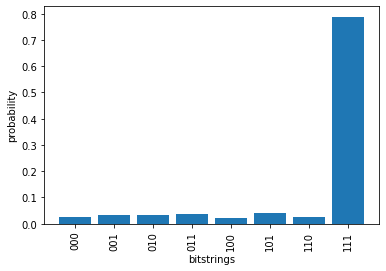

In [12]:
plot_bitstrings_formatted(probabilities)

In [13]:
tracker.stop()
print("Task Summary for device")
print(tracker.quantum_tasks_statistics())

Task Summary for device
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1000, 'tasks': {'COMPLETED': 1}, 'execution_duration': datetime.timedelta(microseconds=19000), 'billed_execution_duration': datetime.timedelta(seconds=3)}}


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).